In [12]:
import numpy as np
from astropy.table import Table

import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization,Dropout
from sklearn.preprocessing import StandardScaler

In [ ]:
def load_and_preprocess_data(filename):
    data = Table.read(filename, format='ascii.csv', header_start=0, data_start=1)

    #ensure no NaN
    valid_sigma_o3_err = (data['sigma_o3_err'] > 0) & np.isfinite(data['sigma_o3_err'])  # valid error values
    valid_sigma_o3 = np.isfinite(data['sigma_o3'])  # valid sigma_o3 values
    valid_data = valid_sigma_o3 & valid_sigma_o3_err  # only keep valid data points
    
    #selection criteria
    ind1 = np.where(data['o3'] / data['o3_err'] > 3)
    ind2 = np.where((data['o21'] + data['o22']) / np.sqrt(data['o21_err']**2 + data['o22_err']**2) > 3)
    ind3 = np.where(data['hb'] / data['hb_err'] > 3)
    ind4 = np.where(data['ha'] / data['ha_err'] > 3)
    ind5 = np.where(data['s21'] / data['s21_err'] > 3)
    ind6 = np.where(valid_data & (data['sigma_o3'] / data['sigma_o3_err'] > 3))  # Only include valid data
    ind7 = np.where(data['VDISP'] > 0.)
    ind8 = np.where(data['mag_u'] > 10.)

    # combine all indices
    ind = np.array(list(set(ind1[0]) & set(ind2[0]) & set(ind3[0]) & set(ind4[0]) & set(ind5[0]) & set(ind6[0]) & set(ind7[0]) & set(ind8[0])))
    
    # split sets
    n_source = len(ind)
    print(n_source)
    n_split = int(n_source * 0.7)
    ind_train, ind_test = ind[:n_split], ind[n_split:]
    print(len(ind_train))

    # feature arrays 
    features_train = {
        'O2_index': np.log10((data['o21'][ind_train] + data['o22'][ind_train]) / data['hb'][ind_train]),
        'O3_index': np.log10(data['o3'][ind_train] / data['hb'][ind_train]),
        'sigma_o3': np.log10(data['sigma_o3'][ind_train]),
        'sigma_star': np.log10(data['VDISP'][ind_train]),
        'u_g': data['mag_u'][ind_train] - data['mag_g'][ind_train],
        'g_r': data['mag_g'][ind_train] - data['mag_r'][ind_train],
        'r_i': data['mag_r'][ind_train] - data['mag_i'][ind_train],
        'i_z': data['mag_i'][ind_train] - data['mag_z'][ind_train],
    }

    features_test = {
        'O2_index': np.log10((data['o21'][ind_test] + data['o22'][ind_test]) / data['hb'][ind_test]),
        'O3_index': np.log10(data['o3'][ind_test] / data['hb'][ind_test]),
        'sigma_o3': np.log10(data['sigma_o3'][ind_test]),
        'sigma_star': np.log10(data['VDISP'][ind_test]),
        'u_g': data['mag_u'][ind_test] - data['mag_g'][ind_test],
        'g_r': data['mag_g'][ind_test] - data['mag_r'][ind_test],
        'r_i': data['mag_r'][ind_test] - data['mag_i'][ind_test],
        'i_z': data['mag_i'][ind_test] - data['mag_z'][ind_test],
    }

    # assign labels
    type_arr_train = np.full(len(ind_train), -999)
    type_arr_test = np.full(len(ind_test), -999)

    ind_sf = np.where(features_train['O3_index'] <= (0.61 / (features_train['O2_index'] - 0.05) + 1.3))
    ind_AGN = np.where(features_train['O3_index'] > (0.61 / (features_train['O2_index'] - 0.47) + 1.19))
    ind_liner = np.where(features_train['O3_index'] > (0.61 / (features_train['O2_index'] - 0.47) + 1.19))
    ind_comp = np.where((features_train['O3_index'] > (0.61 / (features_train['O2_index'] - 0.05) + 1.3)) & 
                         (features_train['O3_index'] < (0.61 / (features_train['O2_index'] - 0.47) + 1.19)))

    type_arr_train[ind_sf] = 1
    type_arr_train[ind_comp] = 2
    type_arr_train[ind_AGN] = 3
    type_arr_train[ind_liner] = 4

    ind_sf_test = np.where(features_test['O3_index'] <= (0.61 / (features_test['O2_index'] - 0.05) + 1.3))
    ind_AGN_test = np.where(features_test['O3_index'] > (0.61 / (features_test['O2_index'] - 0.47) + 1.19))
    ind_liner_test = np.where(features_test['O3_index'] > (0.61 / (features_test['O2_index'] - 0.47) + 1.19))
    ind_comp_test = np.where((features_test['O3_index'] > (0.61 / (features_test['O2_index'] - 0.05) + 1.3)) & 
                              (features_test['O3_index'] < (0.61 / (features_test['O2_index'] - 0.47) + 1.19)))

    type_arr_test[ind_sf_test] = 1
    type_arr_test[ind_comp_test] = 2
    type_arr_test[ind_AGN_test] = 3
    type_arr_test[ind_liner_test] = 4

    return features_train, type_arr_train, features_test, type_arr_test


features_train, type_arr_train, features_test, type_arr_test = load_and_preprocess_data('data_matched_step2_newz_sm.csv')


6513
4559


In [35]:
from sklearn.model_selection import train_test_split

# features array and target vectors (y)
X_train = np.column_stack([features_train['O2_index'], features_train['O3_index'], features_train['sigma_o3'],
                           features_train['sigma_star'], features_train['u_g'], features_train['g_r'], 
                           features_train['r_i'], features_train['i_z']])

X_test = np.column_stack([features_test['O2_index'], features_test['O3_index'], features_test['sigma_o3'],
                          features_test['sigma_star'], features_test['u_g'], features_test['g_r'],
                          features_test['r_i'], features_test['i_z']])

y_train = to_categorical(type_arr_train - 1, num_classes=4)
y_test = to_categorical(type_arr_test - 1, num_classes=4)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

model = Sequential()
model.add(Dense(32,name="fc1", input_shape=(8,)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(64, name="fc2"))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(64, name="fc3"))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary(show_trainable=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ fc1 (Dense)                 │ (None, 32)            │        288 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_24 (Activation)  │ (None, 32)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_24      │ (None, 32)            │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8 (Dropout)         │ (None, 32)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc2 (Dense)                 │ (None, 64)            │      2,112 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_25 (Activation)  │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_25      │ (None, 64)            │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_9 (Dropout)         │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc3 (Dense)                 │ (None, 64)            │      4,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_26 (Activation)  │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_26      │ (None, 64)            │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_10 (Dropout)        │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_13 (Dense)            │ (None, 64)            │      4,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_27 (Activation)  │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_27      │ (None, 64)            │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_11 (Dropout)        │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14 (Dense)            │ (None, 4)             │        260 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 11,876 (46.39 KB)

 Trainable params: 11,428 (44.64 KB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
model_history = model.fit(X_train_split, y_train_split, epochs=20, batch_size=32,verbose=1,shuffle=True, validation_data=(X_val_split, y_val_split))

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3774 - loss: 1.6382 - val_accuracy: 0.7325 - val_loss: 0.9258
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6796 - loss: 0.8900 - val_accuracy: 0.7840 - val_loss: 0.6187
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7284 - loss: 0.7130 - val_accuracy: 0.8300 - val_loss: 0.4705
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7860 - loss: 0.5667 - val_accuracy: 0.8136 - val_loss: 0.4623
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8121 - loss: 0.4910 - val_accuracy: 0.8366 - val_loss: 0.3832
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8314 - loss: 0.4428 - val_accuracy: 0.9090 - val_loss: 0.2525
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8352 - loss: 0.4108 - val_accuracy: 0.9353 - val_loss: 0.2194
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8572 - loss: 0.3615 - val_accuracy: 0.

In [37]:
pred = model.predict(X_test,verbose=0)

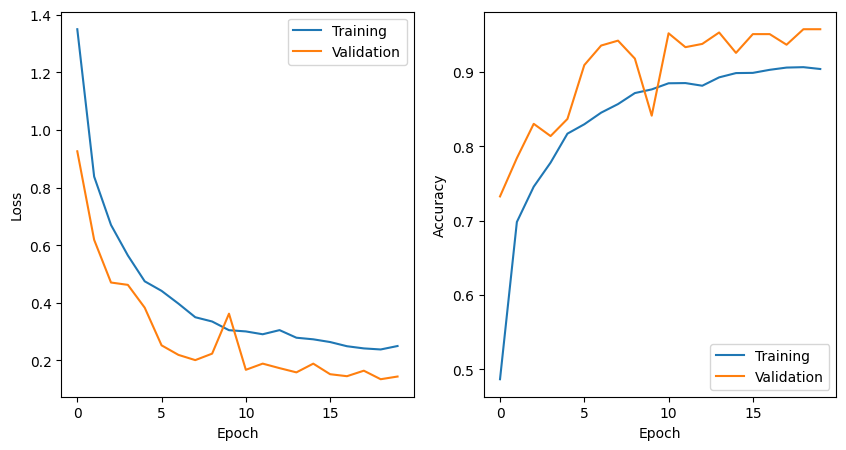

In [38]:
from plotting import plot_model_history

plot_model_history(model_history)

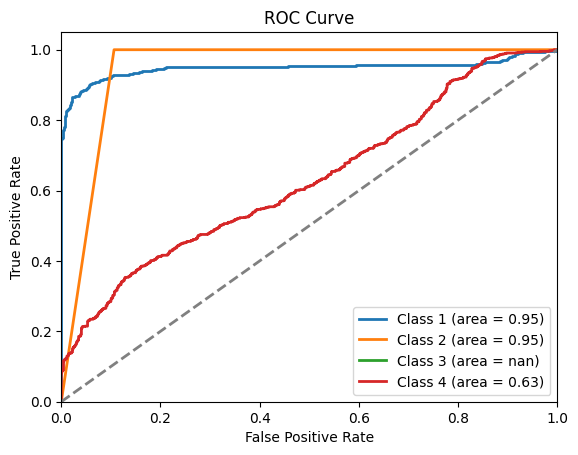

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = pred

fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i+1} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(loc='lower right')
plt.show()
